In [4]:
import polars as pl
import polars as pl
from sklearn.metrics import (confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, r2_score, 
								mean_squared_error, mean_absolute_error, accuracy_score, f1_score, median_absolute_error)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union, Tuple, List, Optional
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from collections.abc import Callable
from optuna.samplers import TPESampler
import optuna

import os
import re
import logging
from pathlib import Path
import polars as pl
from collections.abc import Callable

import polars as pl
import logging
import ast
import os

from pathlib import Path
from scipy.stats import zscore
from pathlib import Path
from collections.abc import Callable

# Training Regressor Model

### Modelling Framework

In [18]:
import polars as pl

class Dataloader:

    """ Dataloader is an iterator which loads data sequentially in batches"""

    def __init__(self, batch_size : int) -> None:
        self.batch_size = batch_size
        self._index = 0

    def fit(self, X : pl.DataFrame, y : pl.Series) -> None:
        self.X = X
        self.y = y
        self.len = len(self.y)

    def __iter__(self):
        return self
   
    def __next__(self):
       
        if self._index >= self.len:
            raise StopIteration

        start = self._index
        end = min(self.len, self._index + self.batch_size)

        X_batch = self.X[start : end]
        y_batch = self.y[start : end]
        self._index += self.batch_size

        return X_batch, y_batch
   

class TrainValidationSplit:

    """
    TrainValidationSplit is a class which handles the splitting of data
    into training and validation sets using a specified ratio
    """

    def __init__(self, val_ratio : float, random_state : int = None):
        self.val_ratio = val_ratio
        self.train_ratio = 1 - self.val_ratio
        self.random_state = random_state

        # Assert value range
        assert self.train_ratio > 0, 'specfied ratio out of range'
        assert self.train_ratio < 1, 'specified ratio out of range'

    def X_y_split(self, df, target_col):
        return df.drop(target_col), df[target_col]

    def data_split(self, df):

        # Split train and validation sets
        df = df.sample(fraction = 1, shuffle = True)
        val_num_rows = int(self.val_ratio * df.shape[0])      
        df_val, df_train = df.head(val_num_rows), df.tail(-val_num_rows)

        return df_train, df_val


class TimeSplit:

    """
    TimeSplit is a class which handles the splitting of data into a test set
    """

    def __init__(self, time_cutoff : str) -> None:
        self.time_cutoff = time_cutoff


    def X_y_split(self, df, target_col):
        return df.drop(target_col), df[target_col]

    def data_split(self, df, time_col):
        if df[time_col].dtype != pl.Datetime:
            df = df.with_columns(
                pl.col(time_col).str.to_datetime(format="%Y-%m-%d %H:%M:%S%.f")
            )      
        parsed_time_cutoff = pl.lit(self.time_cutoff).str.to_datetime(format="%Y-%m-%d") 
        df_test = df.filter(pl.col(time_col) > parsed_time_cutoff)
        df_leftover = df.filter(pl.col(time_col) <= parsed_time_cutoff)
        return df_test, df_leftover
   
import polars as pl
from sklearn.metrics import (confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, r2_score,
mean_squared_error, mean_absolute_error, accuracy_score, f1_score, median_absolute_error)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union, Tuple, List, Optional
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
# from data import Dataloader


class Evaluation:
    """
    Evaluation is the parent class of ClassificationEvaluation and RegressionEvaluation.
    """
    def __init__(self, model):
        """
        Initialize with a model
        """
        self.model = model
       
    def plot_feature_importance(self, X, y, save_path=None):
        ax = xgb.plot_importance(self.model)
        save_path = f"/kaggle/working/{save_path}"
        if save_path:
            plt.savefig(save_path, bbox_inches="tight", dpi=300)
            print(f"Feature importance plot saved as: {save_path}")
        
        plt.show()
        return ax


class ClassificationEvaluation(Evaluation):
    """
    ClassificationEvaluation is an evaluation framework for classification models.
    """
    def __init__(self, model):
        self.model = model
   
    def get_classification_metrics(self, X, y):
        y_pred_proba = self.model.predict_proba(X)[:, 1]
        y_pred = self.model.predict(X)
       
        clf_metrics = {
            'Accuracy': accuracy_score(y, y_pred),
            'F1': f1_score(y, y_pred),
            'AUC': roc_auc_score(y, y_pred_proba),
            'Confusion Matrix': confusion_matrix(y, y_pred)
        }

        for name, score in clf_metrics.items():
            print(f'{name}:\n{score}')
       
        # return clf_metrics
   
    def plot_roc_curve(self, X, y):
        y_pred_proba = self.model.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y, y_pred_proba)
        auc = roc_auc_score(y, y_pred_proba)
        plt.plot(fpr, tpr, label="AUC=" + str(round(auc, 3)))
        plt.legend(loc=4)
        plt.show()

    def plot_learning_curve(self):
        results = self.model.evals_result()
        epochs = len(results['validation_0']['logloss'])
        x_axis = range(0, epochs)
   
        plt.figure(figsize=(6, 6))
        plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
        plt.plot(x_axis, results['validation_1']['logloss'], label='Validation')
        plt.xlabel("Epochs")
        plt.ylabel("Log Loss")
        plt.title("Learning Curve")
        plt.legend()
        plt.show()


class RegressionEvaluation(Evaluation):
    """
    RegressionEvaluation is an evaluation framework for regression models
    which outputs the relevant metrics and figures for analysis.
    """
    def __init__(self, model):
        super().__init__(model)
   
    def get_regression_metrics(self, X, y):
        y_pred = self.model.predict(X)
        reg_metrics = {
            'R2': r2_score(y, y_pred),
            'MSE': mean_squared_error(y, y_pred),
            'MAE': median_absolute_error(y, y_pred),
        }

        for name, score in reg_metrics.items():
            print(f'{name}:\n{score}')
        # return reg_metrics

    def plot_learning_curve(self, save_path= None):
        results = self.model.evals_result()
        epochs = len(results['validation_0']['rmse'])
        x_axis = range(0, epochs)
   
        plt.figure(figsize=(6, 6))
        plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
        plt.plot(x_axis, results['validation_1']['rmse'], label='Validation')
        plt.xlabel("Epochs")
        plt.ylabel("RMSE")
        plt.title("Learning Curve")
        plt.legend()
        save_path = f"/kaggle/working/{save_path}"
        if save_path:
            plt.savefig(save_path, bbox_inches="tight", dpi=300)
            print(f"Feature importance plot saved as: {save_path}")
        
        plt.show()


from xgboost import XGBRegressor, XGBClassifier
# from data import Dataloader


class Trainer:
    def __init__(self, model_cls, dataloader):
        self.model_cls = model_cls
        self.dataloader = dataloader

    def fit(self, X, y, params):

        # Initialize and train model
        self.model = self.model_cls(**params)
        self.model.fit(X, y)
        return self.model

    def fit_batch(self, X, y, params):
       
        # Initialize model
        not_trained = True
        self.model = self.model_cls(**params)

        # Initialize dataloader and train by batch
        self.dataloader.fit(X, y)
        for X_batch, y_batch in self.dataloader:
            print("hheloo")
            if not_trained:
                print("????")
                self.model.fit(X_batch, y_batch)
                not_trained = False
            else:
                print("!!!!!")
                self.model.fit(X_batch, y_batch, xgb_model = self.model.get_booster())
        return self.model

from collections.abc import Callable
from optuna.samplers import TPESampler
import optuna



class Optimizer:

    """ Optimizer is class used for optimizing an Optuna objective"""

    def __init__(self, n_trials : int = 100, random_state : int = 42):

        # Initialize object fields
        self.n_trials = n_trials
        self.random_state = random_state

        optuna.logging.get_verbosity()
        optuna.logging.INFO
        # Create study
        self.sampler = TPESampler(seed = self.random_state)
        self.study = optuna.create_study(sampler = self.sampler, direction='minimize') # minimize logloss


    def optimize(self, objective : Callable) -> dict:
        study = optuna.create_study(objective, self.n_trials)
        return study.best_params


class HyperparameterObjective:

    """
    HyperparameterObjective is an class that makes a hyperparameter tuning objective,
    which tunes a model's hyperparameters using a validation set and an evaluation metric
    """

    def __init__(self, trainer, splitter):
        self.trainer = trainer
        self.splitter = splitter

    def clean_data(self, X, y):
        y = y.cast(pl.Float32)
        mask = (~y.is_null()) & (~y.is_nan()) & (~y.is_infinite()) & ((y == 0) | (y == 1))
        return X.filter(mask), y.filter(mask)

    def make_objective(self, model, df, config : dict, metric) -> Callable:

        def objective(trial):

            # Make sure that splitter is undeterminisitic to avoid overfitting
            self.splitter.random_state = None

            # Split data into training and validation features and targets
            df_train, df_val = self.splitter.data_split(df)
            X_train, y_train = self.splitter.X_y_split(df_train, 'target')
            X_val, y_val = self.splitter.X_y_split(df_val, 'target')

             # Apply cleaning
            X_train, y_train = self.clean_data(X_train, y_train)
            X_val, y_val = self.clean_data(X_val, y_val)
            
            # Suggest hyperparameter based on config
            model_params = {}
            for name, attr in config.items():

                # Get variables from config
                suggest_vartype = f"suggest_{attr['type']}"
                suggest_params = attr['params']

                # Suggest corresponding value and save to model_params
                val = getattr(trial, suggest_vartype)(name, *attr['params'])
                model_params[name] = val

            # Train model
            fitted = self.trainer.fit_batch(X_train, y_train, model_params)
            if metric.__name__ == "log_loss":
                y_pred = fitted.predict_proba(X_val)[:, 1]
            else:
                y_pred = fitted.predict(X_val) 
            
            return metric(y_val, y_pred)


        return objective


## import data


In [68]:
df = pl.read_parquet('/kaggle/input/eda-dataset/preprocessed_data.parquet')
df

user_id_first,device_family_linux_max,device_family_mac os x_max,device_family_windows_max,region_grouped_international_max,region_grouped_midwest_max,region_grouped_northeast_max,region_grouped_south_max,region_grouped_west_max,event_category_account & policy management_max,event_category_action center & workflow_max,event_category_dashboard & ui interactions_max,event_category_other/system events_max,event_category_session & navigation_max,event_category_submission & forms_max,uw_max,admin_max,manager_max,broker_max,google_max,microsoft_max,client_event_hour_mean,client_upload_hour_mean,event_hour_mean,server_received_hour_mean,server_upload_hour_mean,time_to_server_mean,server_to_process_mean,processing_time_mean,user_id,returned_within_7_days,session_seconds
str,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,i8,i8,i8,i8,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,str,i8,i64
"""23948c43-0a67-46af-9ac4-7c2934…",0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,14.294521,14.369863,14.294521,14.369863,14.369863,871.828767,0.0,0.527397,"""23948c43-0a67-46af-9ac4-7c2934…",1,437
"""88e62b40-bf38-4d53-9728-30184d…",0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,15.578947,14.0,15.578947,14.0,14.0,1.8971e6,0.0,0.552632,"""88e62b40-bf38-4d53-9728-30184d…",1,2699
"""897ef84b-cbc9-4c72-8bff-d35bfd…",0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,7.386207,7.372414,7.386207,7.372414,7.372414,857.77931,0.0,0.6,"""897ef84b-cbc9-4c72-8bff-d35bfd…",1,7104
"""2960eb27-039a-4489-94eb-670e48…",0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,16.0,16.0,16.0,16.0,16.0,2.482759,0.0,6.862069,"""2960eb27-039a-4489-94eb-670e48…",0,126
"""9cadb195-5205-414d-bac7-3d96d2…",0,0,1,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,9.45781,9.48833,9.45781,9.48833,9.48833,733.199282,0.0,5.971275,"""9cadb195-5205-414d-bac7-3d96d2…",1,16858
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""abe2a8ce-bdc7-4dfb-be98-2d8802…",0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,14.0,14.0,14.0,14.0,14.0,3.866667,0.0,1.766667,"""abe2a8ce-bdc7-4dfb-be98-2d8802…",1,647
"""27f310fe-0840-488c-a98f-d5083d…",0,0,1,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,18.946996,17.0,18.946996,17.0,17.0,1.3732e7,0.0,0.713781,"""27f310fe-0840-488c-a98f-d5083d…",1,9262
"""dc56ed4b-87e2-4c13-85b0-5e11f1…",0,0,1,0,0,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0,9.378151,4.0,9.378151,4.0,4.0,3.1772e6,0.0,0.369748,"""dc56ed4b-87e2-4c13-85b0-5e11f1…",1,20182


In [7]:
df = df.with_columns(
 pl.col('user_id_first').map_elements(lambda x: x[-1], return_dtype=pl.String).alias('train')
) 

In [8]:
df['train'].value_counts().with_columns(
    pl.col('count').map_elements(lambda x: x/df.shape[0])
)

<ipython-input-8-e72ca0130cb4>:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df['train'].value_counts().with_columns(


train,count
str,f64
"""2""",0.074499
"""c""",0.073022
"""0""",0.068592
"""9""",0.050382
"""e""",0.04778
…,…
"""a""",0.059254
"""4""",0.064082
"""b""",0.078271


In [69]:
df = df.drop(["user_id"])

In [7]:
df_test = df.filter((pl.col('train') == '5') | (pl.col('train') == '6'))

In [8]:
df_val = df.filter((pl.col('train') == "0") )

In [9]:
df_train = df.filter((pl.col('train') != '5') & (pl.col('train') != '6') & (pl.col('train') != '0') )

In [70]:
def group_train_validation_split(df, group_col, ratios = (0.8, 0.1, 0.1), random_state = None):


    unique_cat = df[group_col].unique().to_list()
    df = df.sample(fraction = 1, shuffle = True, seed = None)

    # Compute split indices
    n_train = int(len(unique_cat) * ratios[0])
    n_val = int(len(unique_cat) * ratios[1])

    # Assign users to each set
    train_users = set(unique_cat[:n_train])
    val_users = set(unique_cat[n_train:n_train + n_val])
    test_users = set(unique_cat[n_train + n_val:])

    # Filter DataFrame based on user_id sets
    df_train = df.filter(pl.col(group_col).is_in(train_users))
    df_val = df.filter(pl.col(group_col).is_in(val_users))
    df_test = df.filter(pl.col(group_col).is_in(test_users))

    df_train = df_train.drop(group_col)
    df_val = df_val.drop(group_col)
    df_test = df_test.drop(group_col)
    return (df_train, df_val, df_test)


(df_train, df_val, df_test) = group_train_validation_split(df, "user_id_first")

In [71]:
df_train

device_family_linux_max,device_family_mac os x_max,device_family_windows_max,region_grouped_international_max,region_grouped_midwest_max,region_grouped_northeast_max,region_grouped_south_max,region_grouped_west_max,event_category_account & policy management_max,event_category_action center & workflow_max,event_category_dashboard & ui interactions_max,event_category_other/system events_max,event_category_session & navigation_max,event_category_submission & forms_max,uw_max,admin_max,manager_max,broker_max,google_max,microsoft_max,client_event_hour_mean,client_upload_hour_mean,event_hour_mean,server_received_hour_mean,server_upload_hour_mean,time_to_server_mean,server_to_process_mean,processing_time_mean,returned_within_7_days,session_seconds
u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,i8,i8,i8,i8,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,i8,i64
0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,11.0,21.0,11.0,21.0,21.0,1074709.5,0.0,0.0,1,2
0,0,1,0,1,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,19.402532,19.412658,19.402532,19.412658,19.412658,473.427848,0.0,2.2,1,12499
0,0,1,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,18.34058,18.34058,18.34058,18.34058,18.34058,615.246377,0.0,4.014493,1,4706
0,0,1,0,0,0,1,0,1,0,0,1,1,1,0,0,1,0,0,0,17.611111,17.611111,17.611111,17.611111,17.611111,3.0,0.0,2.444444,1,1540
0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,17.083333,17.083333,17.083333,17.083333,17.083333,1.75,0.0,0.666667,1,432
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,0,1,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,14.573333,14.573333,14.573333,14.573333,14.573333,-19.408889,0.0,0.671111,1,2568
0,1,0,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,15.918605,15.936047,15.918605,15.936047,15.936047,1566.354651,0.0,0.738372,1,2867
0,0,1,0,0,1,0,0,1,0,1,1,1,0,0,0,1,0,0,0,16.395349,17.0,16.395349,17.0,17.0,1.9183e7,0.0,7.790698,1,6318


# Training

## Data Split

In [72]:
train_validation_split = TrainValidationSplit(val_ratio = 0.01, random_state = 42)

target_col = "session_seconds"

# Use the X_y_split method from TrainValidationSplit
X_train, y_train = train_validation_split.X_y_split(df_train, target_col)
X_val, y_val = train_validation_split.X_y_split(df_val, target_col)
X_test, y_test = train_validation_split.X_y_split(df_test, target_col)

# Clean data function
def clean_data(X, y):
    mask = ~(y.is_null() | y.is_infinite())
    return X.filter(mask), y.filter(mask)

# Apply cleaning to pre-split data
X_train, y_train = clean_data(X_train, y_train)
X_val, y_val = clean_data(X_val, y_val)
X_test, y_test = clean_data(X_test, y_test)

# Initialize Trainer

In [73]:
# Initialize trainer and dataloader
dataloader = Dataloader(batch_size = 500000)
trainer = Trainer(XGBRegressor, dataloader)


# Specify model parameters
params = {'eval_set' : [(X_train, y_train), (X_val, y_val)]}

In [74]:
params = {
    'reg_lambda': 1.0, 
    'reg_alpha': 0.5,   
    'max_depth': 6,     
    'min_child_weight': 5,
}

# Train initial model
model = trainer.fit_batch(X_train, y_train, params)

# Add evaluation sets for learning curve
eval_set = [(X_train, y_train), (X_val, y_val)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)


hheloo
????


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Evaluation

In [75]:
eval_classifier = RegressionEvaluation(model)


Test Set Metrics:
R2:
0.4150731788975246
MSE:
20462751.320107624
MAE:
1837.6360473632812
Plotting Learning Curve:
Feature importance plot saved as: /kaggle/working/reg_learning_curve_new.png


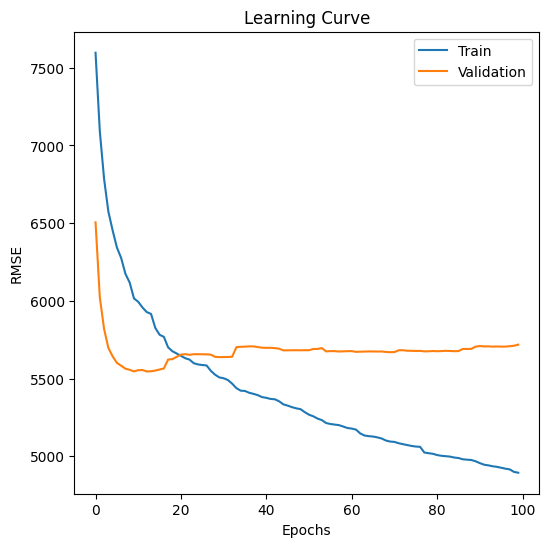

Plotting Feature Importance:
Feature importance plot saved as: /kaggle/working/reg_feature_importance_new.png


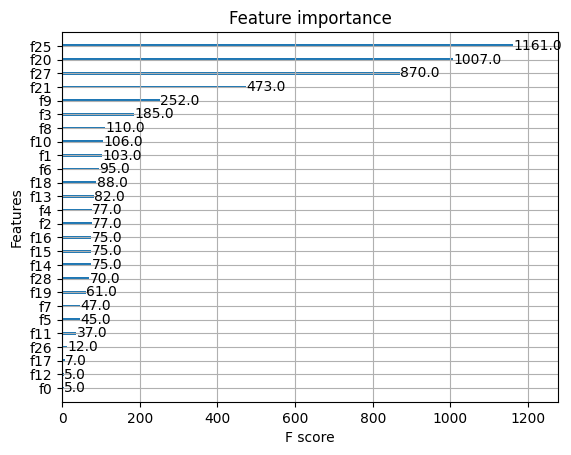

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

In [79]:
print("\nTest Set Metrics:")
eval_classifier.get_regression_metrics(X_test, y_test)

print("Plotting Learning Curve:")
eval_classifier.plot_learning_curve(save_path="reg_learning_curve_new.png")

print("Plotting Feature Importance:")
eval_classifier.plot_feature_importance(X_test, y_test, save_path="reg_feature_importance_new.png")

NameError: name 'save_path' is not defined

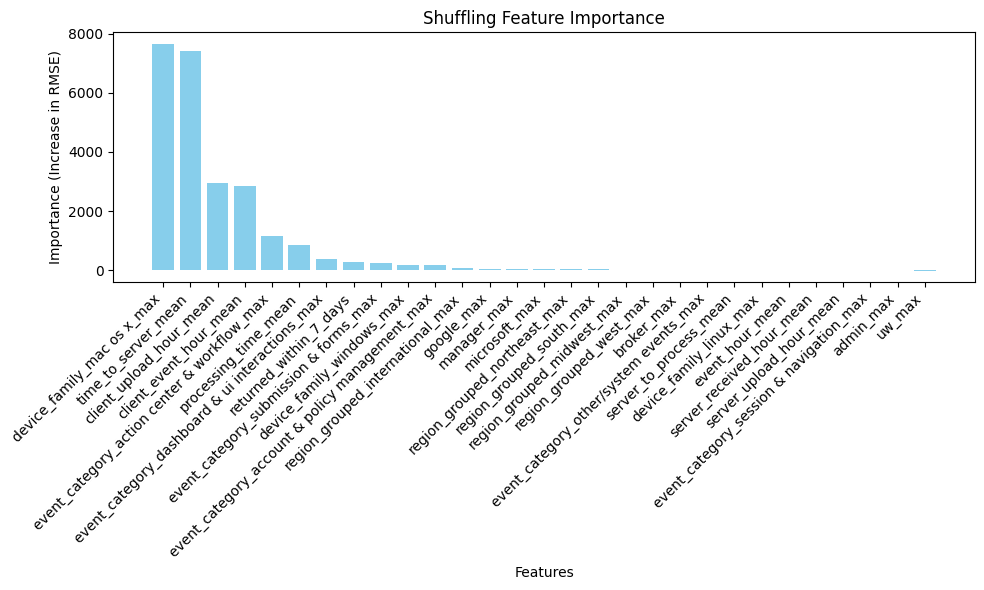

In [77]:
import polars as pl
import numpy as np
from sklearn.metrics import mean_squared_error

def shuffling_feature_importance(model, X_test, y_test):
    y_test_array = y_test.to_numpy() if isinstance(y_test, pl.Series) else y_test

    # Calculate the baseline performance using RMSE
    baseline = np.sqrt(mean_squared_error(y_test_array, model.predict(X_test)))

    importances = {}

    # Iterate over each feature to shuffle
    for col in X_test.columns:
        # Create a copy of X_test (Polars DataFrames are immutable, so we use with_columns)
        X_shuffled = X_test.clone()
        
        # Shuffle the column using numpy's permutation and replace it in the DataFrame
        shuffled_values = np.random.permutation(X_shuffled[col].to_numpy())
        X_shuffled = X_shuffled.with_columns(pl.Series(col, shuffled_values))

        # Measure performance after shuffling
        shuffled_rmse = np.sqrt(mean_squared_error(y_test_array, model.predict(X_shuffled)))
        
        # Calculate the increase in RMSE (higher = more important)
        importances[col] = shuffled_rmse - baseline
    
    # Convert the importances dictionary to a Polars DataFrame
    importance_df = pl.DataFrame({
        "Feature": list(importances.keys()),
        "Importance": list(importances.values())
    })
    
    importance_df = importance_df.sort("Importance", descending=True)

    plt.figure(figsize=(10, 6))
    plt.bar(importance_df["Feature"], importance_df["Importance"], color='skyblue')
    plt.xlabel("Features")
    plt.ylabel("Importance (Increase in RMSE)")
    plt.title("Shuffling Feature Importance")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('\kaggle\working\shuffling_feature_importance.png', bbox_inches="tight", dpi=300)
    print(f"Feature importance plot saved as: {save_path}")
    plt.show()

    return importance_df

importance_df = shuffling_feature_importance(model, X_test, y_test)
importance_df

In [59]:
def get_random_feature_importance(model, X_train, y_train):

    # Get feature importance
    rng = np.random.RandomState(42)
    X_train = X_train.with_columns(pl.Series('random', rng.randn(X_train.shape[0], 1,).flatten()))
    model.fit(X_train, y_train)
    feature_importance = model.get_booster().get_score(importance_type = 'gain')

    # Map back to columns
    feature_map = {f"f{i}": col for i, col in enumerate(X_train.columns)}
    renamed_importance_dict = {feature_map[k]: v for k, v in feature_importance.items()}
    sorted_importance_dict = dict(sorted(renamed_importance_dict.items(), key=lambda item: item[1], reverse=True))

    return sorted_importance_dict

get_random_feature_importance(model, X_train, y_train)

ValueError: Must have at least 1 validation dataset for early stopping.

# Optimization

In [66]:
import optuna
import xgboost as xgb
import polars as pl
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

# Hyperparameter Tuning Objective (Using RMSE)
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 0, 5),
        "alpha": trial.suggest_float("alpha", 0, 5),
        "objective": "reg:squarederror",  # Regression objective
        "eval_metric": "rmse",             # Evaluate using RMSE
        "random_state": 42,
    }

    # Train Model
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train, 
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=10,  # optional early stopping
        verbose=False
    )

    # Predict
    y_pred = model.predict(X_val)

    # Compute RMSE
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    return rmse

# Run Optuna Optimization
study = optuna.create_study(direction="minimize")  # We minimize RMSE
study.optimize(objective, n_trials=100)            # Adjust the number of trials as needed

print("Best Hyperparameters:", study.best_params)

# Utility: Get Random Feature Importance
def get_random_feature_importance(model, X_train, y_train):
    """
    Fits the model on X + a random column, then returns a dictionary 
    of sorted feature importances. 
    """
    rng = np.random.RandomState(42)
    
    # Add a random column (important to avoid mutating the original X_train)
    X_with_random = X_train.with_columns(
        pl.Series('random', rng.randn(X_train.shape[0]))
    )
    
    model.fit(X_with_random, y_train)
    feature_importance = model.get_booster().get_score(importance_type='gain')

    # Map XGBoost's f0, f1, ... back to actual column names
    feature_map = {f"f{i}": col for i, col in enumerate(X_with_random.columns)}
    renamed_importance_dict = {feature_map[k]: v for k, v in feature_importance.items()}
    sorted_importance_dict = dict(
        sorted(renamed_importance_dict.items(), key=lambda item: item[1], reverse=True)
    )

    return sorted_importance_dict

# Utility: Identify Unimportant Columns
def get_unimportant_columns(model, X_train, y_train):
    """
    Trains model with a random column added, then returns columns 
    whose feature importance is below that of the random column.
    """
    sorted_importance_dict = get_random_feature_importance(model, X_train, y_train)
    
    # If 'random' wasn't used (rare edge case), just return empty
    if 'random' not in sorted_importance_dict:
        return []
    
    random_importance = sorted_importance_dict['random']
    
    # Unimportant columns have less 'gain' than 'random'
    return [col for col, val in sorted_importance_dict.items() if val < random_importance]


[I 2025-02-25 04:37:38,393] A new study created in memory with name: no-name-5f3257dc-b3e0-4aff-8874-bd82f65bcef6
[W 2025-02-25 04:37:38,432] Trial 0 failed with parameters: {'max_depth': 10, 'learning_rate': 0.2907966442641858, 'n_estimators': 285, 'min_child_weight': 3, 'subsample': 0.5592073619410372, 'colsample_bytree': 0.8524734825065489, 'gamma': 3.647446301620284, 'lambda': 4.95006865350741, 'alpha': 1.5836718989694458} because of the following error: XGBoostError('[04:37:38] /workspace/src/data/data.cc:507: Check failed: valid: Label contains NaN, infinity or a value too large.\nStack trace:\n  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3588ca) [0x7f550c1e68ca]\n  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x38a21d) [0x7f550c21821d]\n  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x38ab51) [0x7f550c218b51]\n  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.

XGBoostError: [04:37:38] /workspace/src/data/data.cc:507: Check failed: valid: Label contains NaN, infinity or a value too large.
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3588ca) [0x7f550c1e68ca]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x38a21d) [0x7f550c21821d]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x38ab51) [0x7f550c218b51]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGDMatrixSetInfoFromInterface+0xb0) [0x7f550bfec3a0]
  [bt] (4) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f5574d00e2e]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f5574cfd493]
  [bt] (6) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f5574d273e9]
  [bt] (7) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x9a00) [0x7f5574d26a00]
  [bt] (8) /usr/bin/python3(_PyObject_MakeTpCall+0x25b) [0x58d1926e9b4b]



In [36]:
# Train Final Model with Best Parameters
best_params = study.best_params
final_model = xgb.XGBRegressor(**best_params)
eval_set = [(X_train, y_train), (X_val, y_val)]
final_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Make Predictions
y_pred = final_model.predict(X_val)


Test Set Metrics:
R2:
0.44389496091980263
MSE:
29564519.12559289
MAE:
1876.1577758789062
Plotting Learning Curve:
Feature importance plot saved as: /kaggle/working/None


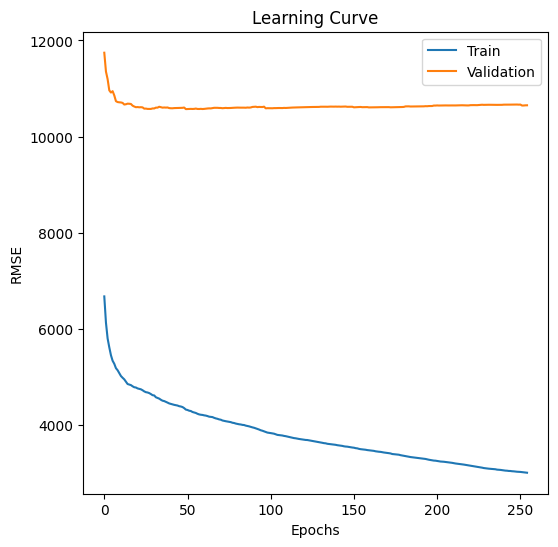

Plotting Feature Importance:
Feature importance plot saved as: /kaggle/working/None


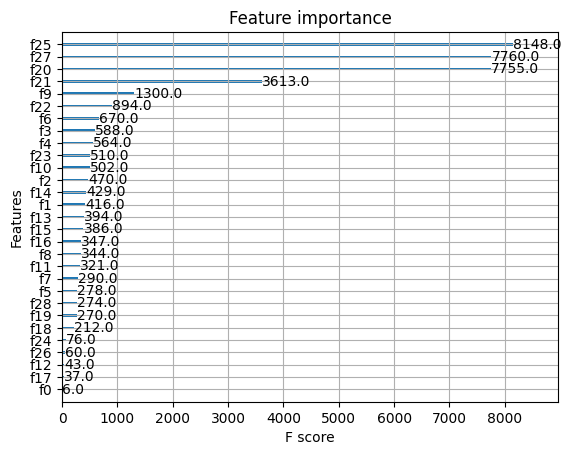

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

In [37]:
# Evaluate Model
eval_classifier = RegressionEvaluation(final_model)
print("\nTest Set Metrics:")
eval_classifier.get_regression_metrics(X_test, y_test)

print("Plotting Learning Curve:")
eval_classifier.plot_learning_curve()

print("Plotting Feature Importance:")
eval_classifier.plot_feature_importance(X_test, y_test)


In [78]:
import pickle

# Define the filename for saving the model
model_filename = "xgb_regressor_new.pkl"

# Save the model using pickle
with open(model_filename, "wb") as file:
    pickle.dump(model, file)

print(f"Model saved successfully as {model_filename}")


Model saved successfully as xgb_regressor_new.pkl
